Setup

In [ ]:
import os

DATA_DIR = os.path.join(os.path.abspath(''), 'tsplib-data')
PROBLEMS_DIR = os.path.join(DATA_DIR, 'problems')
FEATURES_DIR = os.path.join(DATA_DIR, 'npy')
# See the functions dict (line 478) in ./optlearn/optlearn/feature/features.py
# For any feature computation function named compute_fX_edges, you can add fX here
# DESIRED_EDGE_FEATURES = ['fg']
# DESIRED_EDGE_FEATURES = ['fa', 'fb', 'fc', 'fd', 'fe', 'ff', 'fg', 'fi', 'fj']
DRAW = False # Display edges with weights and features in build_features

Building features

In [5]:
from optlearn.experiments.build_data import build_features
build_features(FEATURES_DIR, PROBLEMS_DIR, DESIRED_EDGE_FEATURES)


Status:
Directory Status: Checked/Built


Iteration 1 of 4
Iteration 2 of 4
Iteration 3 of 4
Iteration 4 of 4
Problem 1 of 1 completed

Status:
Directory Status: Checked/Built
Features Status: Checked/Built/Written
Current Problem: N/A


Done! :D


Printing and visualizing features

Features for ulysses16.tsp:
['fg']


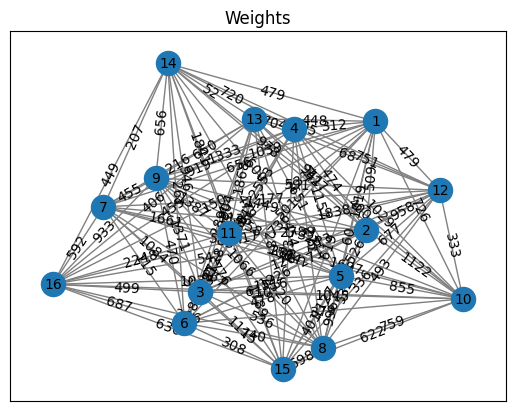

0 (1, 2): [0.5]
1 (1, 3): [0.75]
2 (1, 4): [0.5]
3 (1, 5): [0.]
4 (1, 6): [0.]
5 (1, 7): [0.]
6 (1, 8): [0.25]
7 (1, 9): [0.]
8 (1, 10): [0.]
9 (1, 11): [0.]
10 (1, 12): [0.75]
11 (1, 13): [0.5]
12 (1, 14): [1.]
13 (1, 15): [0.]
14 (1, 16): [0.25]
15 (2, 3): [0.25]
16 (2, 4): [0.25]
17 (2, 5): [0.]
18 (2, 6): [0.]
19 (2, 7): [0.]
20 (2, 8): [0.75]
21 (2, 9): [0.]
22 (2, 10): [0.]
23 (2, 11): [0.]
24 (2, 12): [0.]
25 (2, 13): [0.]
26 (2, 14): [0.]
27 (2, 15): [0.]
28 (2, 16): [1.]
29 (3, 4): [1.]
30 (3, 5): [0.]
31 (3, 6): [0.]
32 (3, 7): [0.]
33 (3, 8): [1.]
34 (3, 9): [0.]
35 (3, 10): [0.]
36 (3, 11): [0.]
37 (3, 12): [0.]
38 (3, 13): [0.]
39 (3, 14): [0.]
40 (3, 15): [0.]
41 (3, 16): [0.5]
42 (4, 5): [0.]
43 (4, 6): [0.]
44 (4, 7): [0.]
45 (4, 8): [0.25]
46 (4, 9): [0.]
47 (4, 10): [0.]
48 (4, 11): [0.]
49 (4, 12): [0.]
50 (4, 13): [0.]
51 (4, 14): [0.]
52 (4, 15): [0.]
53 (4, 16): [0.75]
54 (5, 6): [0.5]
55 (5, 7): [0.75]
56 (5, 8): [0.]
57 (5, 9): [0.]
58 (5, 10): [0.]
59 (5, 11): 

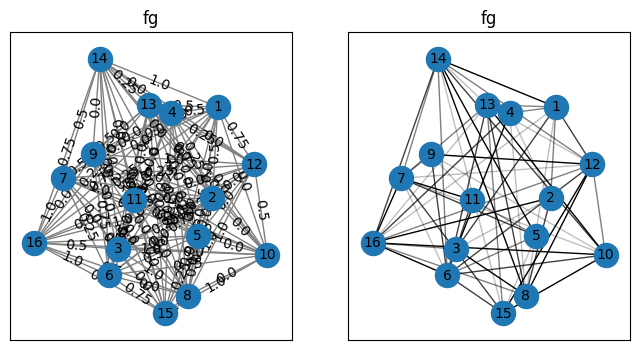

In [11]:
from optlearn.data.data_utils import dataLoader
# FULL_FEATURE_NAMES = [f'compute_{name}_edges' for name in DESIRED_EDGE_FEATURES]
loader = dataLoader([]) # how can we input the data_pairs if we don't have the data yet?

import networkx as nx
from optlearn.graph_utils import get_edges, get_weights
from optlearn.io_utils import optObject

# Note: We're not using optlearn.plotting.plot_graph because it isn't very 
# helpful here - it doesn't show numerical values
# from optlearn.plotting import plot_graph
import matplotlib.pyplot as plt

PYPLOT_WIDTH_INCHES = 4 * 2
PYPLOT_HEIGHT_INCHES = 4 * len(DESIRED_EDGE_FEATURES)
ARC_RADIUS = 0.15

def draw_full_graph(ax=None, use_alpha=False):
	nx.draw_networkx_nodes(G, pos, ax=ax)
	nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
	connectionstyle = 'arc3' + (f',rad={ARC_RADIUS}' if G.is_directed() else '')
	nx.draw_networkx_edges(
		G,
		pos,
		edge_color=('black' if use_alpha else 'grey'),
		ax=ax,
		alpha=(features_data[:,feature_idx] if use_alpha else 1),
		connectionstyle=connectionstyle
	)
	if not use_alpha:
		nx.draw_networkx_edge_labels(
			G,
			pos,
			labels,
			label_pos=(0.3 if G.is_directed() else 0.5),
			bbox={"alpha": 0},
			ax=ax,
			connectionstyle=connectionstyle
		)

for problem_file_name in os.listdir(PROBLEMS_DIR):
	# 2. Prints features
	print(f'Features for {problem_file_name}:')
	print(DESIRED_EDGE_FEATURES)
	feature_file_name = problem_file_name.replace('.tsp', '.npy')
	features_data = loader.load_features([
		os.path.join(FEATURES_DIR, feature, feature_file_name)
		for feature in DESIRED_EDGE_FEATURES])

	# 3. Plots each feature as a separate graph
	problem_file_path = os.path.join(PROBLEMS_DIR, problem_file_name)
	# Returns graph with N(N - 1) edges (all directed edges besides loops)
	G = optObject().read_problem_from_file(problem_file_path).get_graph()
	edges = get_edges(G)
	weights = get_weights(G)
	pos = nx.spring_layout(G)
	
	labels = {}
	for edge_idx, edge in enumerate(edges):
		labels[edge] = weights[edge_idx]
	draw_full_graph()
	plt.title('Weights')
	plt.show()

	# Based on
	# https://networkx.org/documentation/latest/auto_examples/drawing/plot_multigraphs.html#sphx-glr-auto-examples-drawing-plot-multigraphs-py
	fig, ax = plt.subplots(len(DESIRED_EDGE_FEATURES), 2)
	# Standardizes ax as a 2D list
	if len(DESIRED_EDGE_FEATURES) == 1:
		ax = [ax]
	for edge_idx, edge in enumerate(edges):
		print(f'{edge_idx} {edge}: {features_data[edge_idx]}')
	for feature_idx, feature in enumerate(DESIRED_EDGE_FEATURES):
		labels = {}
		for edge_idx, edge in enumerate(edges):
			labels[edge] = round(features_data[edge_idx][feature_idx], 3)
		
		ax_numeric = ax[feature_idx][0]
		draw_full_graph(ax=ax_numeric)
		ax_numeric.set_title(feature)

		ax_alpha = ax[feature_idx][1]
		draw_full_graph(ax=ax_alpha, use_alpha=True)
		ax_alpha.set_title(feature)
	fig.set_size_inches(PYPLOT_WIDTH_INCHES, PYPLOT_HEIGHT_INCHES)
	plt.show()
